
# Step 2: Distribution forecasting

We are going to forecast distribution parameters, so a distribution for electricity prices must be picked. Johnson's SU is a distribution, that is commonly used for pricing, including electricity.

First, import from pickle

In [1]:
import pickle
import os
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
import math


path = os.getcwdb().decode("utf-8")+"/data"

In [2]:
scaler_x, X_scaled, y_a1, y_a2, y_sp, X_test_scaled, y_test_a1, y_test_a2, y_test_sp, feature_names, imp_order = pickle.load(open(path+"/pickle_1.pkl", "rb"))

To make learning more stable, I first calculate a baseline fit, and the network will only predict deviations from the baseline.

In [3]:
from scipy.stats import johnsonsu, uniform

Import more packages:

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Embedding, Reshape
from tensorflow.keras.optimizers import Adam
import tensorflow_probability as tfp
import optuna
import random

Data preparation

In [5]:
y_a1 = tf.convert_to_tensor(y_a1, dtype='float32')
y_a2 = tf.convert_to_tensor(y_a2, dtype='float32')
y_sp = tf.convert_to_tensor(y_sp, dtype='float32')

In [6]:
y_test_a1 = tf.convert_to_tensor(y_test_a1, dtype='float32')
y_test_a2 = tf.convert_to_tensor(y_test_a2, dtype='float32')
y_test_sp = tf.convert_to_tensor(y_test_sp, dtype='float32')

In [7]:
window_length = 720
batch_size = 128

In [8]:
train_size = X_scaled.shape[0]
test_size = X_test_scaled.shape[0]
number_of_iterations = math.ceil(test_size/window_length)

In [11]:
dataset = tf.data.Dataset.from_tensor_slices(
    (X_scaled
     , y_a1
     , y_a2
     , y_sp
    )).shuffle(len(X_scaled), seed=5).batch(batch_size)

test_datasets = ['dummy']
for i in range(1,number_of_iterations):    
    test_dataset = tf.data.Dataset.from_tensor_slices(
        (X_test_scaled[(i-1)*window_length:i*window_length]
         , y_test_a1[(i-1)*window_length:i*window_length]
         , y_test_a2[(i-1)*window_length:i*window_length]
         , y_test_sp[(i-1)*window_length:i*window_length]
        )).shuffle(len(X_scaled), seed=5).batch(batch_size)
    test_datasets.append(test_dataset)


The Distribution Neural Network. A standard MLP with two hidden layers, but with a custom loss function. It calculates the negative log-likelihood of the Johnson's SU. The output are (scaled) parameter deviations from the baseline

In [12]:
@tf.function
def nll(y_true, y_pred):
    gamma=y_pred[:,0]               #a
    delta=K.abs(y_pred[:,1])+0.001        #b
    xi=y_pred[:,2]                  #loc
    lmbda=K.abs(y_pred[:,3])+0.001       #scale

    ll = tfp.distributions.JohnsonSU(
        skewness = gamma,
        tailweight = delta,
        loc = xi,
        scale = lmbda,
        validate_args=True
    ).log_prob(y_true)
        
    return -tf.reduce_mean(ll)

In [13]:
l1_neurons = 100
l2_neurons = 50
l3_neurons = 25
l2_reg = 0.0001
dropout_rate = 0.3


inputs = tf.keras.Input(shape=(X_scaled.shape[1],))


hidden = tf.keras.layers.Dense(
            l1_neurons,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
        )(inputs)

hidden = tf.keras.layers.Dropout(
            dropout_rate
        )(hidden)

hidden = tf.keras.layers.Dense(
            l2_neurons,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
        )(hidden)

hidden = tf.keras.layers.Dropout(
            dropout_rate
        )(hidden)

hidden = tf.keras.layers.Dense(
            l3_neurons,
            activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
        )(hidden)

hidden = tf.keras.layers.Dropout(
            dropout_rate
        )(hidden)


output_a1 = tf.keras.layers.Dense(4, activation="linear", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(hidden)
output_a2 = tf.keras.layers.Dense(4, activation="linear", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(hidden)
output_sp = tf.keras.layers.Dense(4, activation="linear", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(hidden)

model = tf.keras.Model(inputs=inputs, outputs=[output_a1, output_a2, output_sp], name='Model')
    


    
 

In [14]:
model.summary()

Model: "Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 100)          4100        ['input_1[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 100)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 50)           5050        ['dropout[0][0]']                
                                                                                              

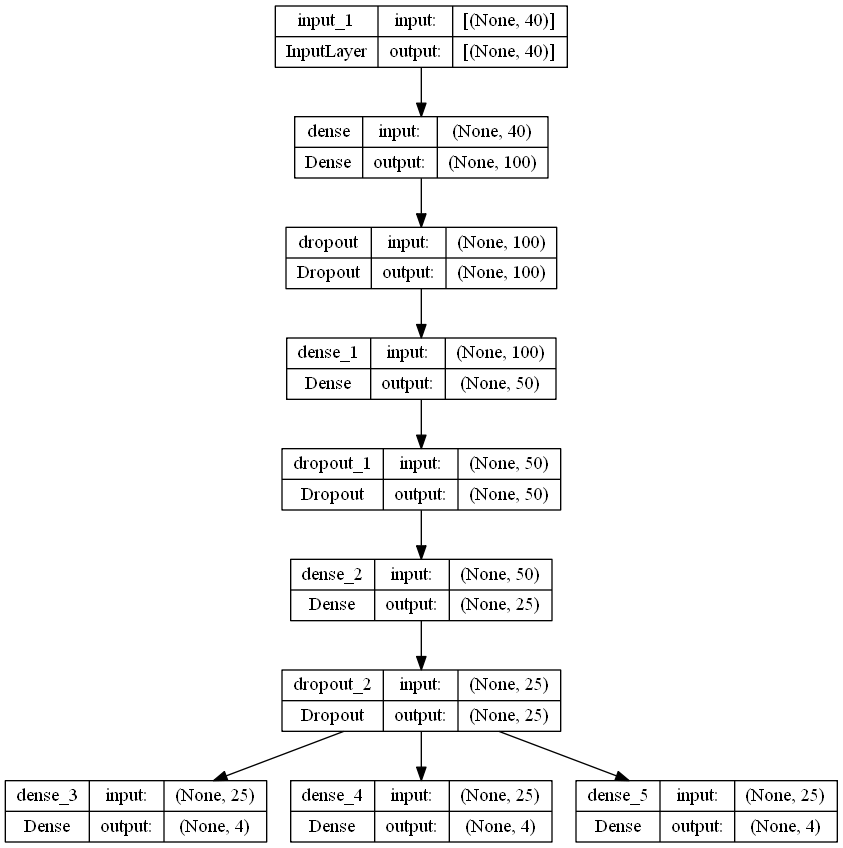

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

Start of training with monthly retraining

In [43]:
def get_model():
    l1_neurons = 100
    l2_neurons = 50
    l3_neurons = 25
    l2_reg = 0.0001
    dropout_rate = 0.3


    inputs = tf.keras.Input(shape=(X_scaled.shape[1],))


    hidden = tf.keras.layers.Dense(
                l1_neurons,
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            )(inputs)

    hidden = tf.keras.layers.Dropout(
                dropout_rate
            )(hidden)

    hidden = tf.keras.layers.Dense(
                l2_neurons,
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            )(hidden)

    hidden = tf.keras.layers.Dropout(
                dropout_rate
            )(hidden)

    hidden = tf.keras.layers.Dense(
                l3_neurons,
                activation='relu',
                kernel_regularizer=tf.keras.regularizers.l2(l2_reg),
            )(hidden)

    hidden = tf.keras.layers.Dropout(
                dropout_rate
            )(hidden)


    output_a1 = tf.keras.layers.Dense(4, activation="linear", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(hidden)
    output_a2 = tf.keras.layers.Dense(4, activation="linear", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(hidden)
    output_sp = tf.keras.layers.Dense(4, activation="linear", kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(hidden)

    model = tf.keras.Model(inputs=inputs, outputs=[output_a1, output_a2, output_sp], name='Model')
    
    return model

In [44]:
train_loss = []

In [45]:
predictions = None

In [46]:
epochs = 150
model = get_model()


for i in range(number_of_iterations): 
    learning_rate  = 0.01
    if i > 0:
        epochs = 20

    for _ in range(2):
        learning_rate = learning_rate/10

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        @tf.function
        def train_model(model, x, y, optimizer):
            with tf.GradientTape() as tape:
                tape.watch(model.trainable_variables)
                y_pred = model(x, training=True)
                loss = nll(y[0], y_pred[0]) + nll(y[1], y_pred[1]) + nll(y[2], y_pred[2]) 
                grads = tape.gradient(loss, model.trainable_variables)
                optimizer.apply_gradients(zip(grads, model.trainable_variables))

            return loss

        # Custom training loop
        
        for _ in tqdm(range(epochs)):
            epoch_loss = []
            if i == 0:
                for batch in dataset:
                    loss=train_model(model=model, x=batch[0], y=[batch[1], batch[2], batch[3]], optimizer=optimizer)
                    epoch_loss.append(loss.numpy())
            else:
                for batch in test_datasets[i]:
                    loss=train_model(model=model, x=batch[0], y=[batch[1], batch[2], batch[3]], optimizer=optimizer)
                    epoch_loss.append(loss.numpy()) 
            
            loss_last_epoch = sum(epoch_loss) / float(len(epoch_loss))
            train_loss.append(loss_last_epoch)
            
       
    preds = model.predict(X_test_scaled[i*window_length:(i+1)*window_length])

    if predictions is None:
        predictions = preds
    else:
        for j in range(3):
            predictions[j] = np.concatenate([predictions[j], preds[j]])

    

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:44<00:00,  3.37it/s]

23/23 [==============================] - 0s 1ms/step



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.41it/s]


23/23 [==============================] - 0s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.71it/s]


23/23 [==============================] - 0s 2ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.45it/s]

23/23 [==============================] - 0s 1ms/step



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.69it/s]


23/23 [==============================] - 0s 1ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.38it/s]

23/23 [==============================] - 0s 2ms/step



100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.95it/s]


12/12 [==============================] - 0s 2ms/step


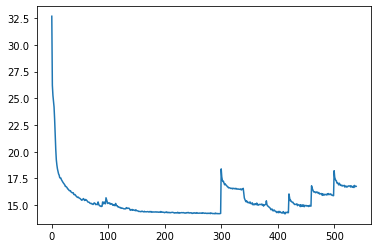

In [47]:
plt.plot(train_loss)

In [48]:
train_predictions = model.predict(X_scaled)

318/318 [==============================] - 0s 1ms/step


In [49]:
a1_predictions = train_predictions[0]

In [50]:
a1_predictions

array([[-28.007631 ,  -7.0443034, -47.176365 ,   9.13968  ],
       [-28.384653 ,  -7.148727 , -48.771423 ,   9.203046 ],
       [-29.904697 ,  -7.581489 , -54.395836 ,   9.489279 ],
       ...,
       [-34.602116 ,  -8.401833 , -74.73255  ,  13.202925 ],
       [-35.297283 ,  -8.563675 , -78.6337   ,  11.673747 ],
       [-31.608154 ,  -7.6285205, -69.81215  ,   9.652443 ]],
      dtype=float32)

In [51]:
testing_start = datetime(2021,1,1,0,0,0)
test_timestamps = [testing_start + timedelta(hours=i) for i in range(len(a1_predictions))]

lb = []
q1 = []
med = []
q3 = []
ub = []
for i in range(len(a1_predictions)):
    y_pred = a1_predictions[i,:]
    gamma=y_pred[0]         #a
    delta=np.abs(y_pred[1])+0.001  #b
    xi=y_pred[2]            #loc
    lmbda=np.abs(y_pred[3])+0.001   #scale
    
    transformed_values = [gamma, delta, xi, lmbda]
    a1 = johnsonsu(*transformed_values)
    quantiles = a1.ppf([0.05,0.25,0.5,0.75,0.95])
    lb.append(quantiles[0])
    q1.append(quantiles[1])
    med.append(quantiles[2])
    q3.append(quantiles[3])
    ub.append(quantiles[4])
    

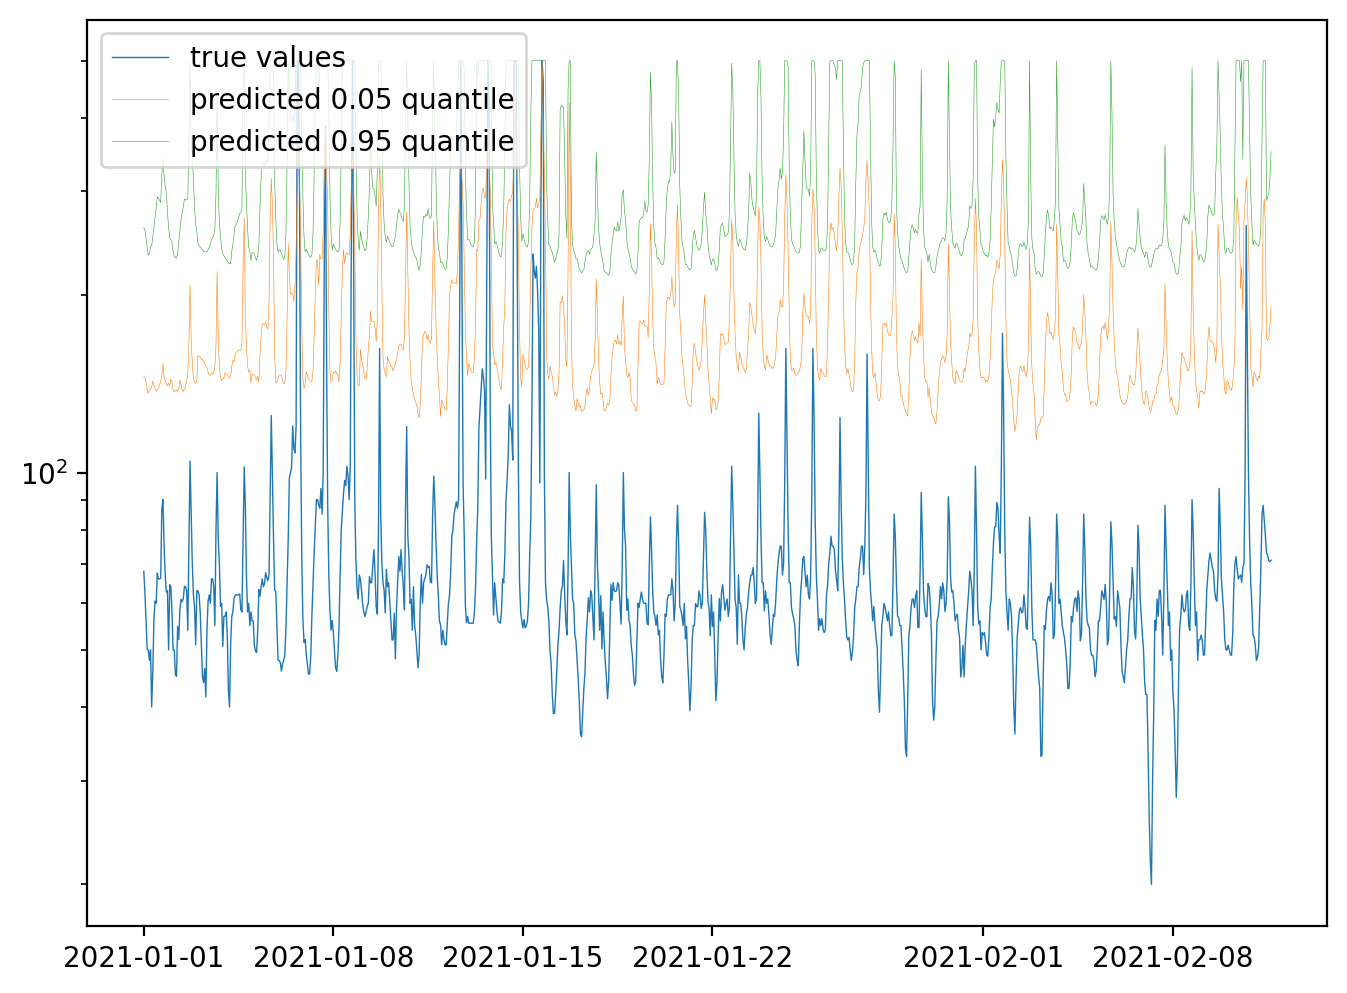

In [52]:
figure(figsize=(8, 6), dpi=200)
plt.yscale('log')
plt.plot(test_timestamps[0:1000], np.clip(y_a1[0:1000], 10, 500), label='true values', linewidth=0.5)
plt.plot(test_timestamps[0:1000], np.clip(lb[0:1000], 10, 500), label='predicted 0.05 quantile', linewidth=0.2)
plt.plot(test_timestamps[0:1000], np.clip(ub[0:1000], 10, 500), label='predicted 0.95 quantile', linewidth=0.2)
plt.legend(loc="upper left")

In [55]:
testing_start = datetime(2021,1,1,0,0,0)
test_timestamps = [testing_start + timedelta(hours=i) for i in range(len(a1_predictions))]

lb = []
q1 = []
med = []
q3 = []
ub = []
for i in range(len(a1_predictions)):
    y_pred = a1_predictions[i,:]
    gamma=y_pred[0]         #a
    delta=np.abs(y_pred[1])+0.001  #b
    xi=y_pred[2]            #loc
    lmbda=np.abs(y_pred[3])+0.001   #scale
    
    transformed_values = [gamma, delta, xi, lmbda]
    a1 = johnsonsu(*transformed_values)
    quantiles = a1.ppf([0.05,0.25,0.5,0.75, 0.95])
    lb.append(quantiles[0])
    q1.append(quantiles[1])
    med.append(quantiles[2])
    q3.append(quantiles[3])
    ub.append(quantiles[4])
    

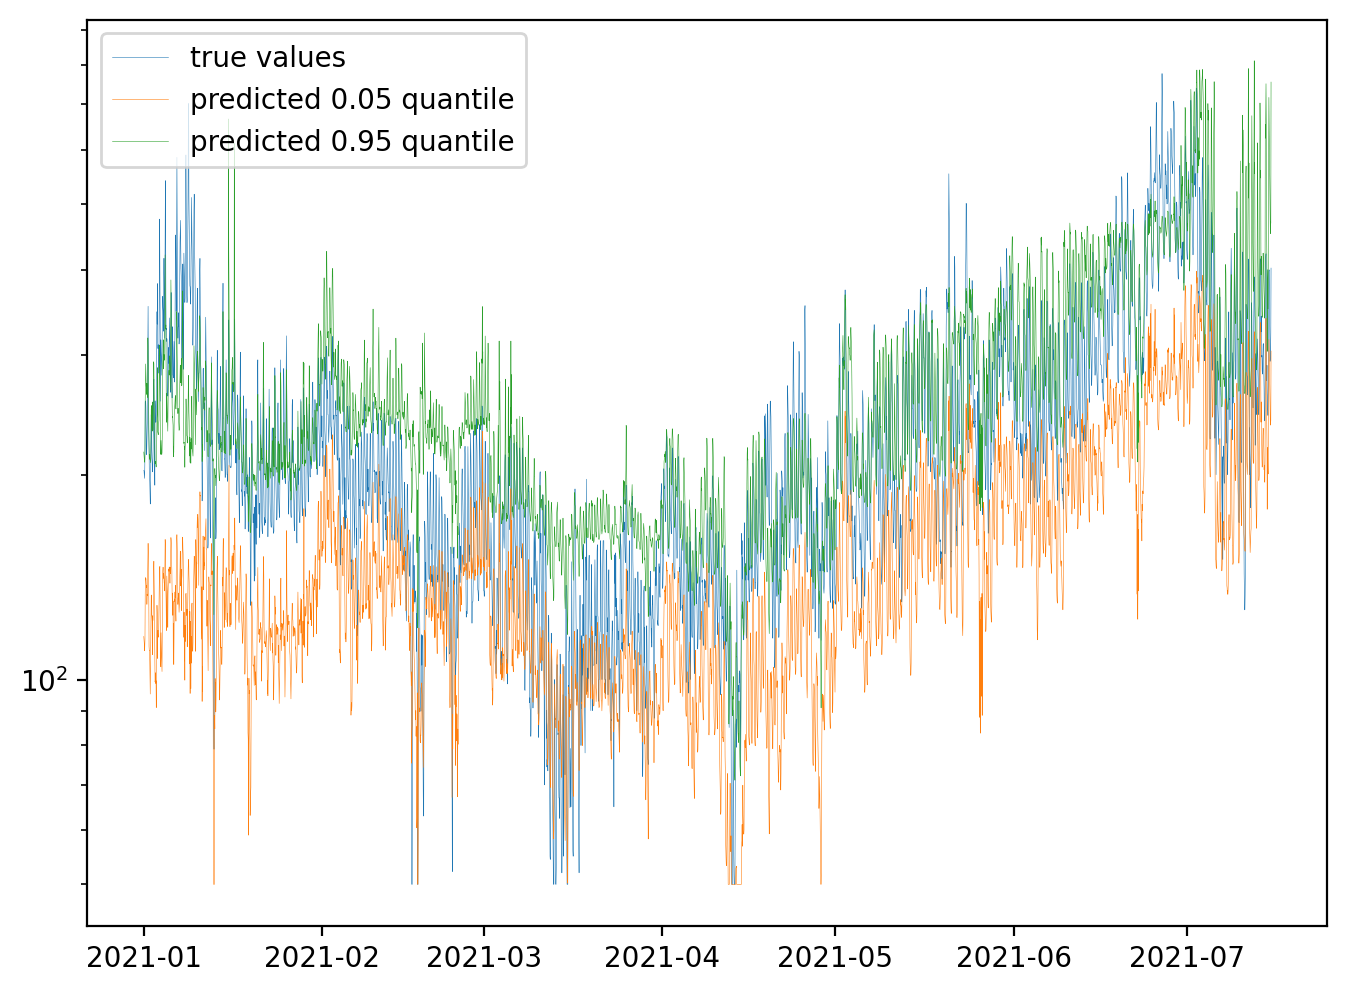

In [56]:
figure(figsize=(8, 6), dpi=200)
plt.yscale('log')
plt.plot(test_timestamps, np.maximum(50,y_test_a1), label='true values', linewidth=0.2)
plt.plot(test_timestamps, np.maximum(50,lb), label='predicted 0.05 quantile', linewidth=0.2)
plt.plot(test_timestamps, np.minimum(10**3,ub), label='predicted 0.95 quantile', linewidth=0.2)
plt.legend(loc="upper left")

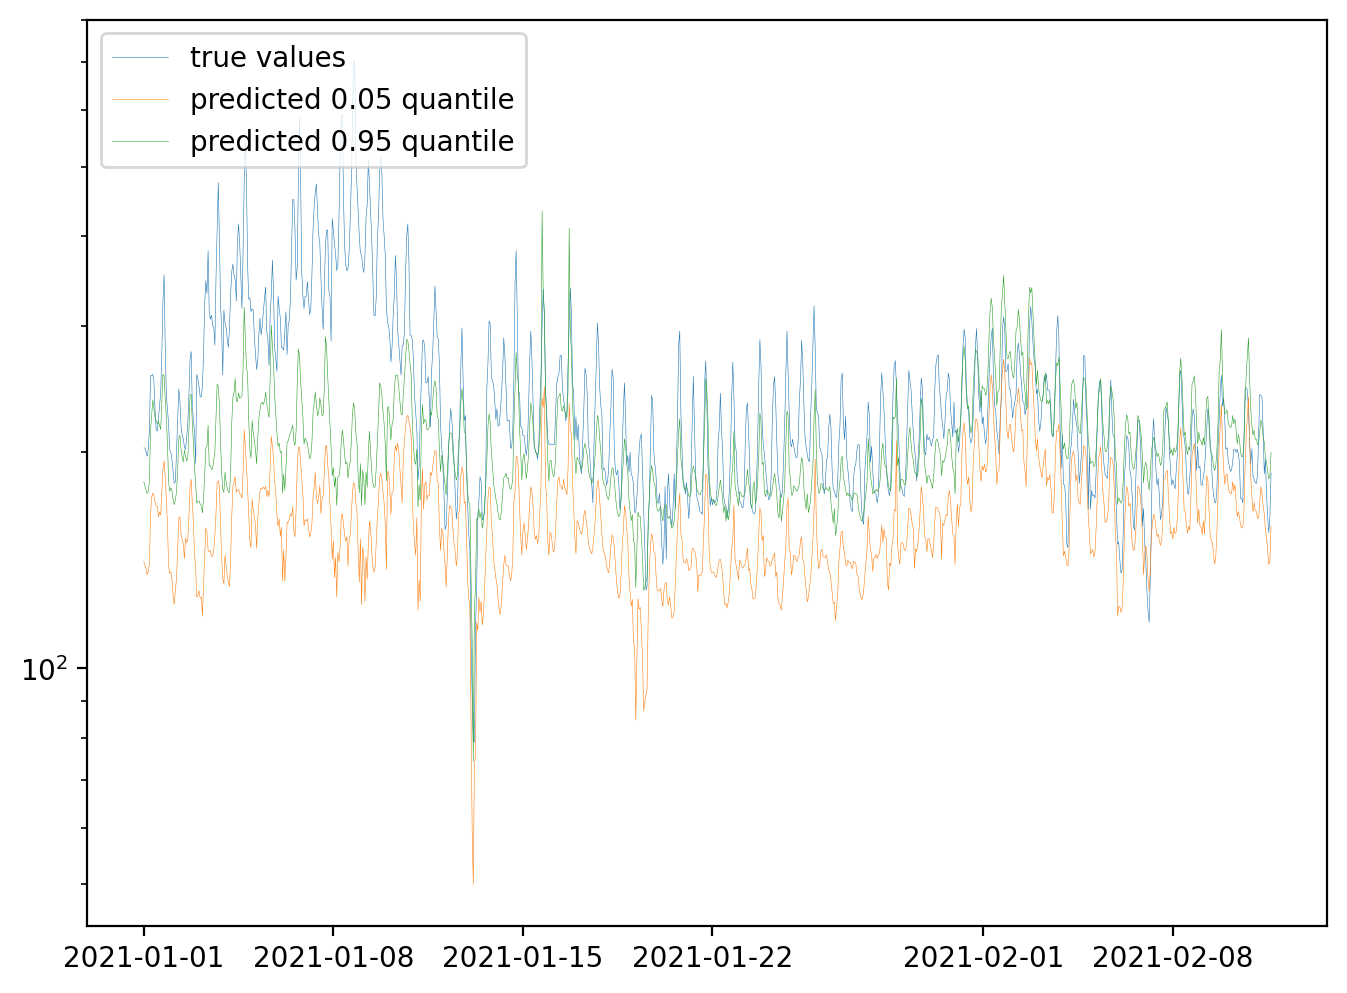

In [57]:
figure(figsize=(8, 6), dpi=200)
plt.yscale('log')
plt.plot(test_timestamps[0:1000], np.maximum(50,y_test_a1[0:1000]), label='true values', linewidth=0.2)
plt.plot(test_timestamps[0:1000], np.maximum(50,q1[0:1000]), label='predicted 0.05 quantile', linewidth=0.2)
plt.plot(test_timestamps[0:1000], np.minimum(10**3,q3[0:1000]), label='predicted 0.95 quantile', linewidth=0.2)
plt.legend(loc="upper left")

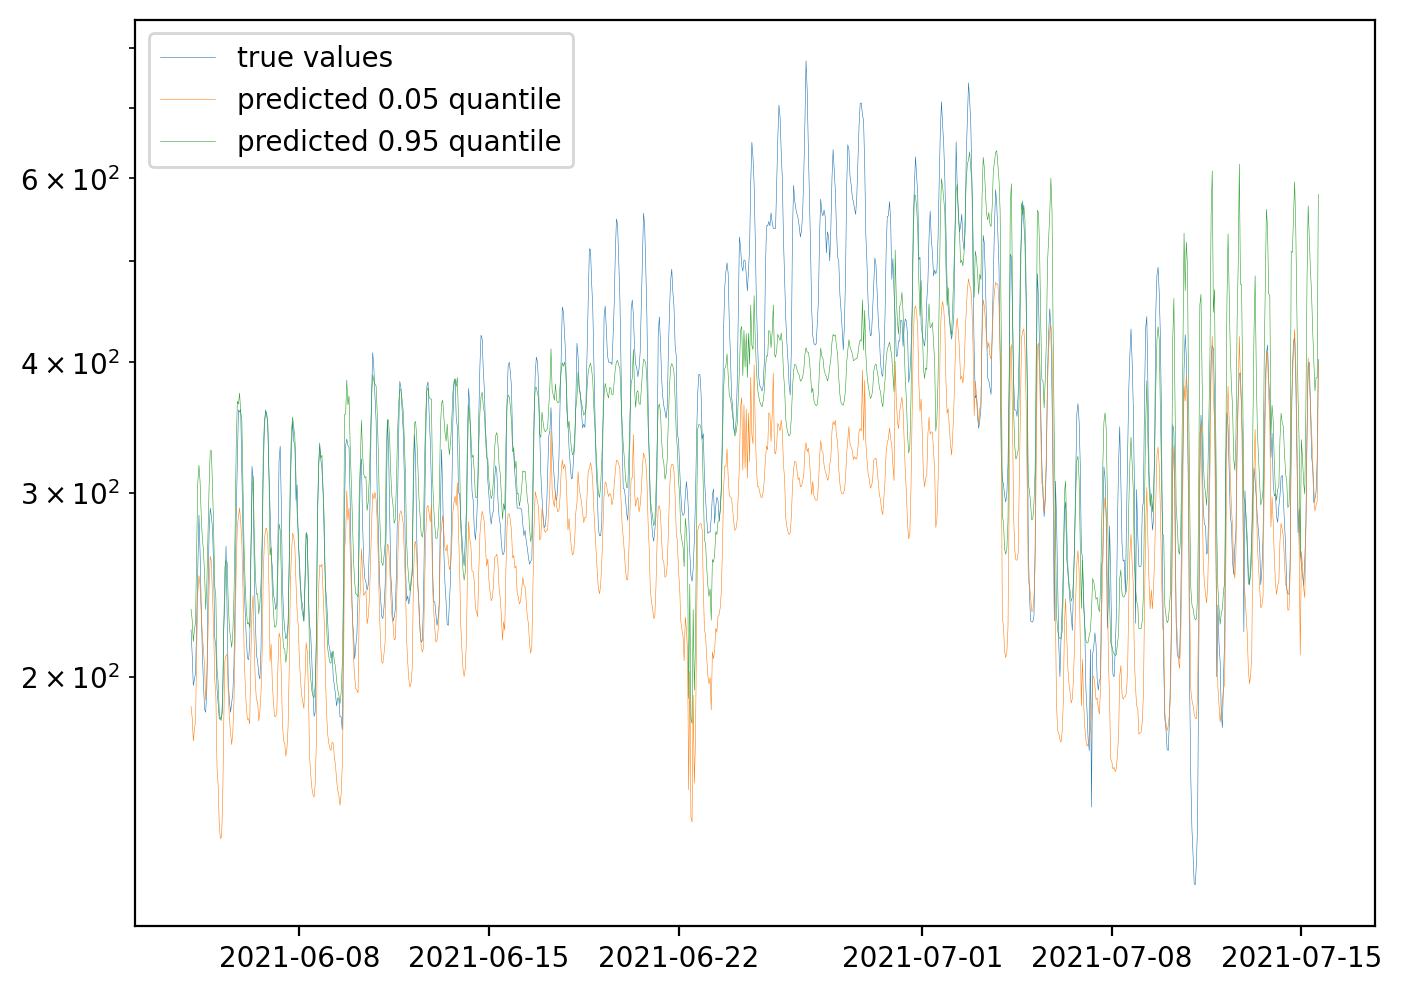

In [58]:
figure(figsize=(8, 6), dpi=200)
plt.yscale('log')
plt.plot(test_timestamps[-1000:], np.maximum(50,y_test_a1[-1000:]), label='true values', linewidth=0.2)
plt.plot(test_timestamps[-1000:], np.maximum(50,q1[-1000:]), label='predicted 0.05 quantile', linewidth=0.2)
plt.plot(test_timestamps[-1000:], np.minimum(10**3,q3[-1000:]), label='predicted 0.95 quantile', linewidth=0.2)
plt.legend(loc="upper left")

Save predictions

In [62]:
pickle_obj = []

for i in range(3):
    pred = predictions[i]
    
    pred[:,1]=np.abs(pred[:,1]+0.001)
    pred[:,3]=np.abs(pred[:,3]+0.001)
    
    pickle_obj.append(pred)


pickle.dump(pickle_obj, open(path+"/FF_predictions.pkl", "wb"))